In [1]:
import sys
sys.path.append('../')
import networkx as nx
from smodels.theory.auxiliaryFunctions import getTreeRoot, elementsInStr, _flattenList
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from smodels.theory.element import Element
from smodels.experiment.finalStateParticles import finalStates
from string import ascii_uppercase

In [10]:
def stringToGraph(info,finalState=None):
    """
    Creates a Graph object from a string in bracket notation.
    
    :parameter info: string describing the element in bracket notation
                     (e.g. [[[e+],[jet]],[[e-],[jet]]])
                     
    :parameter finalState: list containing the final state labels for each branch
                     (e.g. ['MET', 'HSCP'] or ['MET','MET']). If not defined it will
                     be assumed to be MET for all branches
    :return: Tree (nerworkX DiGraph object)
                         
    """


    elements = elementsInStr(info,removeQuotes=False)
    if not elements or len(elements) > 1:
        nel = 0
        if elements:
            nel = len(elements)
        logger.error("Malformed input string. Number of elements "
                      "is %d (expected 1) in: ``%s''", nel, info)
        return None
    
    branches = eval(elements[0])
    if not branches:
        logger.error("Malformed input string. Number of "
                      "branches is %d (expected 2) in: ``%s''",
                      len(branches), info)
        return None

    if finalState:
        if not isinstance(finalState,list) or len(finalState) != len(branches):
            raise SModelSError("Number of final states (%i) does not match number of branches (%i)" 
                               %(len(finalState),len(branches)))
    else:
        finalState = ['MET']*len(branches)

    #Create map with all required particle objects for building the graph:
    fstateDict = {'anyOdd' : finalStates.getParticlesWith(label='anyOdd')[0],
                  'PV' : finalStates.getParticlesWith(label='PV')[0]}
    for ptc in _flattenList(branches) + finalState:
        if not ptc in fstateDict:
            particle = finalStates.getParticlesWith(label=ptc)
            if not particle or len(particle) != 1:
                raise SModelSError("Error retrieving particle %s from finalStateParticles. Is this particle uniquely defined?")
            particle = particle[0]
            fstateDict[ptc] = particle
    
        
    #Store the trees for each branch:
    gBranches = []
    for ib,b in enumerate(branches):
        #Deal with inclusive branches:
        if b == '*':
            from smodels.theory.branch import InclusiveBranch
            fmap = {'anyOdd' : InclusiveBranch(), 
                    finalState[ib] : fstateDict[finalState[ib]]}
            b = [[]]
        else:
            fmap = fstateDict
        #Include final state in the branch list definition
        b.append(finalState[ib])
        gBranches.append(fromListToTree(b,fmap))
    #Now combine the branches:
    branchTags = list(ascii_uppercase)
    newG = nx.DiGraph()    
    for ib,gbranch in enumerate(gBranches):        
        newG = nx.union(newG,gbranch,rename=('',branchTags[ib]))
        nx.relabel_nodes(newG,{'%s0' %branchTags[ib] : 'PV'},copy=False)    
    return newG


def fromListToTree(branchList,particleDict,parentNode=0):
    """
    Converts a branch in bracket notation to a Tree.
    The Tree has a parent which is not physical and
    corresponds to the branch parent (such as the primary vertex)
    
    :param branchList: Branch in bracket notation. It must include the branch final state label
                       (e.g. [ ['e-','e+'],['mu', 'MET'] ])
    :param particleDict: Dictionary to map strings to particle objects.
    :param parentNode: Number of the parent node.
    
    :return: Tree (nerworkX DiGraph object)
    """
    
    anyOdd = particleDict['anyOdd']
    #Create graph and branches
    G = nx.DiGraph()
    #Always include the parent node in the graph:
    momNode = parentNode
    node = 10*parentNode #Get node level (Add digit everytime you increase one level)    
    if parentNode == 0:
        G.add_node(parentNode,particle=particleDict['PV'])
        node += 1
        for vList in branchList:
            node = 10*node
            G.add_node(node,particle=anyOdd)
            G.add_edge(parentNode,node)
            subG = fromListToTree(vList,particleDict,parentNode=momNode)
            G = nx.compose(G,subG)
            momNode = node
    else:
        G.add_node(parentNode,particle=anyOdd)
    node = 10*parentNode #Get node level (Add digit everytime you increase one level)
    momNode = parentNode
    for vList in branchList:
        node += 1
        if isinstance(vList,list):
            G.add_node(node,particle=anyOdd)
            G.add_edge(parentNode,node)
            subG = fromListToTree(vList,particleDict,parentNode=node)
            G = nx.compose(G,subG)
        elif isinstance(vList,str):
            G.add_node(node,particle=particleDict[vList])
            G.add_edge(momNode,node)
    
    return G

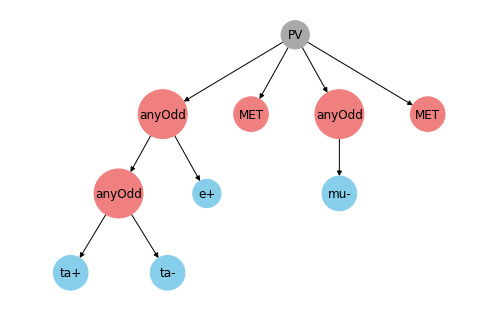

In [11]:
elementStr = "[[[['ta+','ta-'],'e+']],[['mu-']]]"
g = stringToGraph(elementStr)
el = Element(info=g)
el.drawTree()